# Evaluation

In [1]:
# %matplotlib inline

In [2]:
import tensorflow as tf
import cv2
import itertools, os, time
import numpy as np
from Model import get_Model
from parameter import letters
import argparse
from keras import backend as K
K.set_learning_phase(0)
import matplotlib.pyplot as plt
from random import sample
import keras


prov_dict = {'AA' : 'อำนาจเจริญ', 'AB' : 'อ่างทอง', 'AC' : 'กรุงเทพมหานคร', 'AD' :
'บึงกาฬ', 'AE' : 'บุรีรัมย์', 'AF' : 'ฉะเชิงเทรา', 'AG' : 'ชัยนาท', 'AH' : 'ชัยภูมิ',
'AI' : 'จันทบุรี', 'AJ' : 'เชียงใหม่', 'AK' : 'เชียงราย',
'AL' : 'ชลบุรี', 'AM' : 'ชุมพร', 'AN' : 'กาฬสินธุ์', 'AO' : 'กำแพงเพชร',
'AP' : 'กาญจนบุรี', 'AQ' : 'ขอนแก่น', 'AR' : 'กระบี่', 'AS' : 'ลำปาง',
'AT' : 'ลำพูน', 'AU' : 'เลย', 'AV' : 'ลพบุรี', 'AW' : 'แม่ฮ่องสอน', 
'AX' : 'มหาสารคาม', 'AY' : 'มุกดาหาร', 'BA' : 'นครนายก', 'BB' : 'นครปฐม', 
'BC' : 'นครพนม', 'BD' : 'นครราชสีมา', 'BE' : 'นครสวรรค์', 'BF' : 'นครศรีธรรมราช',
'BG' : 'น่าน', 'BH' : 'นราธิวาส', 'BI' : 'หนองบัวลำภู', 'BJ' : 'หนองคาย',
'BK' : 'นนทบุรี', 'BL' : 'ปทุมธานี', 'BM' : 'ปัตตานี', 'BN' : 'พังงา',
'BO' : 'พัทลุง', 'BP' : 'พะเยา', 'BQ' : 'เพชรบูรณ์', 'BR' : 'เพชรบุรี',
'BS' : 'พิจิตร', 'BT' : 'พิษณุโลก', 'BU' : 'พระนครศรีอยุธยา', 'BV' : 'แพร่',
'BW' : 'ภูเก็ต', 'BX' : 'ปราจีนบุรี', 'BY' : 'ประจวบคีรีขันธ์', 
'CA' : 'ระนอง', 'CB' : 'ราชบุรี', 'CC' : 'ระยอง', 'CD' : 'ร้อยเอ็ด', 'CE' : 'สระแก้ว',
'CF' : 'สกลนคร', 'CG' : 'สมุทรปราการ', 'CH' : 'สมุทรสาคร', 'CI' : 'สมุทรสงคราม',
'CJ' : 'สระบุรี', 'CK' : 'สตูล', 'CL' : 'ศรีสะเกษ', 'CM' : 'สิงห์บุรี',
'CN' : 'สงขลา', 'CO' : 'สุโขทัย', 'CP' : 'สุพรรณบุรี', 'CQ' : 'สุราษฎร์ธานี',
'CR' : 'สุรินทร์', 'CS' : 'ตาก', 'CT' : 'ตรัง', 'CU' : 'ตราด', 'CV' :
'อุบลราชธานี', 'CW' : 'อุดรธานี', 'CX' : 'อุทัยธานี', 'CY' : 'อุตรดิตถ์',
'DA' : 'ยะลา', 'DB' : 'ยโสธร'}

char_dict = {'aa' : 'ก', 'ab' : 'ข', 'ac' : 'ค', 'ad' : 'ฆ', 'ae' : 'ง', 'af' : 'จ',
'ag' : 'ฉ', 'ah' : 'ช', 'ai' : 'ซ', 'aj' : 'ฌ', 'ak' : 'ญ', 'al' : 'ฎ',
'am' : 'ฏ', 'an' : 'ฐ', 'ao' : 'ฑ', 'ap' : 'ฒ', 'aq' : 'ณ', 'ar' : 'ด',
'as' : 'ต', 'at' : 'ถ', 'au' : 'ท', 'av' : 'ธ', 'aw' : 'น', 'ax' : 'บ',
'ay' : 'ป', 'ba' : 'ผ', 'bb' : 'ฝ', 'bc' : 'พ', 'bd' : 'ฟ', 'be' : 'ภ',
'bf' : 'ม', 'bg' : 'ย', 'bh' : 'ร', 'bi' : 'ล', 'bj' : 'ว', 'bk' : 'ศ',
'bl' : 'ษ', 'bm' : 'ส', 'bn' : 'ห', 'bo' : 'ฬ', 'bp' : 'อ', 'bq' : 'ฮ'}

def decode_label(out):
    # out : (1, 32, 42)
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr


def label_to_char(label):  # eng -> hangul

    front_num = label[0]
    first_char = label[1:3]
    second_char = label[3:5]
    four_num = label[5:9]
    province = label[9:]


    try:
        first_char = char_dict[first_char]
    except:
        first_char = '?'

    try:
        second_char = char_dict[second_char]
    except:
        second_char = '?'

    try:
        province = prov_dict[province]
    except:
        province = '????'

    return front_num + first_char + second_char + four_num + '-' + province
#     return front_num + first_char + second_char + four_num + province

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [38]:
# Get CRNN model
model = get_Model(training=False)

try:
    model.load_weights('LSTM+BN5--thai-v3.hdf5')
    print("...Previous weight data...")
except:
    raise Exception("No weight file!")

test_dir = './DB/test/'
test_imgs = os.listdir(test_dir)


total = 0
acc = 0
letterprov_total = 0
letterprov_acc = 0

letter_acc = 0
letter_total = 0
province_acc = 0

start = time.time()
for test_img in test_imgs:
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)

    net_out_value = model.predict(img_pred)

    pred_texts = decode_label(net_out_value)

    
    pred_texts_decoded = label_to_char(pred_texts)
    actual_texts_decoded = label_to_char(test_img[0:-4])
    
    # evaluation
    
    # Letter+Province ACC
    for i in range(7):
        if pred_texts_decoded[i] == actual_texts_decoded[i]:
            letterprov_acc += 1
            letter_acc += 1
    if pred_texts_decoded[8:] == actual_texts_decoded[8:]:
        letterprov_acc += 1
        province_acc += 1
    letterprov_total += 8
    letter_total += 7

    # ACC
    if pred_texts == test_img[0:-4]:
        acc += 1
    total += 1
    
#     print(pred_texts)
#     print(test_img[0:-4])
#     print()
#     print('Predicted: %s  /  True: %s' % (label_to_char(pred_texts), label_to_char(test_img[0:-4])))
    print('Predicted:', pred_texts_decoded)
    print('True     :', actual_texts_decoded)
    print('=========================================================')
#     cv2.rectangle(img, (0,0), (150, 30), (0,0,0), -1)
#     cv2.putText(img, pred_texts, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255),2)

#     cv2.imshow("q", img)
#     if cv2.waitKey(0) == 27:
#         break
#     cv2.destroyAllWindows()

end = time.time()
total_time = (end - start)
print()
print("Time                : ", total_time / total)
print('Num test images     : ', total)
print('____________________________________')
print("ACC                 : ", acc / total)
print('____________________________________')
print('letter ACC          : ', letter_acc / letter_total)
print('province ACC        : ', province_acc / total)
print('____________________________________')
print("letter+province ACC : ", letterprov_acc / letterprov_total)

...Previous weight data...
Predicted: 1ณกj449-????
True     : 1กฌ4499-ยะลา
Predicted: 1ก?704C-????
True     : 1กญ3704-อำนาจเจริญ
Predicted: 1กฎ8020-ราชบุรี
True     : 1กฎ8020-อ่างทอง
Predicted: 1กธ7175-เพชรบูรณ์
True     : 1กธ7175-เชียงใหม่
Predicted: 1กผ1259-เพชรบุรี
True     : 1กผ1259-เพชรบุรี
Predicted: 1กผ8731-ราชบุรี
True     : 1กผ8731-ระนอง
Predicted: 1กผ9588-ระนอง
True     : 1กฝ9588-สุโขทัย
Predicted: 1กพ4608-นครศรีธรรมราช
True     : 1กพ4608-ประจวบคีรีขันธ์
Predicted: 1กม6584-สุพรรณบุรี
True     : 1กม6584-สุพรรณบุรี
Predicted: 1กย8873-ยะลา
True     : 1กย8873-ยะลา
Predicted: 1ขซ3423-มุกดาหาร
True     : 1ขซ3423-มุกดาหาร
Predicted: 1ขฬ3690-พิษณุโลก
True     : 1ขฬ3690-พิษณุโลก
Predicted: 1คฌ6626-กำแพงเพชร
True     : 1คฌ6626-กำแพงเพชร
Predicted: 1คท3667-ประจวบคีรีขันธ์
True     : 1คท3667-ประจวบคีรีขันธ์
Predicted: 1คท4160-พิจิตร
True     : 1คท4160-ชุมพร
Predicted: 1คน5480-กาฬสินธุ์
True     : 1คน5480-กาฬสินธุ์
Predicted: 1คป2914-พระนครศรีอยุธยา
True     : 1คป2914-ตรัง
Predicted: 1คม1

Predicted: Zปส7353-นครสวรรค์
True     : Zปส7353-สุพรรณบุรี
Predicted: Zผข9638-ตาก
True     : Zผข9638-น่าน
Predicted: Zผจ2360-อุทัยธานี
True     : Zผจ2360-อุทัยธานี
Predicted: Zผซ6193-กระบี่
True     : Zผซ6193-กระบี่
Predicted: Zผฒ3389-เชียงใหม่
True     : Zผฒ3389-กาญจนบุรี
Predicted: Zผถ5379-ราชบุรี
True     : Zผถ5379-ชัยภูมิ
Predicted: Zผป3243-ราชบุรี
True     : Zผป3243-ราชบุรี
Predicted: Zผม3288-ฉะเชิงเทรา
True     : Zผม3288-ฉะเชิงเทรา
Predicted: Zฝขj861-????
True     : Zผว8617-สงขลา
Predicted: Zผศ407A-????
True     : Zผศ4077-หนองคาย
Predicted: Zผห2428-บุรีรัมย์
True     : Zผห2428-บุรีรัมย์
Predicted: Zผห3447-กาฬสินธุ์
True     : Zผห3447-สุรินทร์
Predicted: Zฝง1099-สตูล
True     : Zฝง1099-ยโสธร
Predicted: Zฝช2635-บึงกาฬ
True     : Zฝช2635-บึงกาฬ
Predicted: Zฝธ1903-ระยอง
True     : Zฝธ1903-ระยอง
Predicted: Zฝป7764-ร้อยเอ็ด
True     : Zฝป7764-ร้อยเอ็ด
Predicted: Zฝม5492-นครศรีธรรมราช
True     : Zฝม5492-นครศรีธรรมราช
Predicted: Zฝ?2233-ชุมพร
True     : Zฝย2233-นครปฐม
Predicted: Zฝห9740-

Predicted: Zฎฎ1875-สตูล
True     : Zษฎ1875-ชัยภูมิ
Predicted: Zษด7668-สุรินทร์
True     : Zษด7668-สุรินทร์
Predicted: Zษต7955-สุพรรณบุรี
True     : Zษต7955-สุพรรณบุรี
Predicted: Zษพ2421-สุรินทร์
True     : Zษพ2421-ชลบุรี
Predicted: Zษร7146-อ่างทอง
True     : Zษร7146-สิงห์บุรี
Predicted: Zษห2622-ร้อยเอ็ด
True     : Zษห2622-มหาสารคาม
Predicted: Zสฎ8906-นครสวรรค์
True     : Zสฎ8906-นครสวรรค์
Predicted: Zสณ5776-????
True     : Zสณ5776-ราชบุรี
Predicted: Zสด3311-พังงา
True     : Zสด3311-พิจิตร
Predicted: Zสด3782-สุราษฎร์ธานี
True     : Zสด3782-สระแก้ว
Predicted: Zสด6230-จันทบุรี
True     : Zสด6230-จันทบุรี
Predicted: Zสว5194-ระยอง
True     : Zสว5194-ระยอง
Predicted: Zสศ3168-กาฬสินธุ์
True     : Zสศ3168-ลำปาง
Predicted: Zสอ3273-บึงกาฬ
True     : Zสอ3273-อุตรดิตถ์
Predicted: Zสอ7794-สระแก้ว
True     : Zสอ7794-สระแก้ว
Predicted: Zสฮ1740-สมุทรสงคราม
True     : Zสฮ1740-สมุทรสงคราม
Predicted: Zหค9259-กำแพงเพชร
True     : Zหค9259-ลำปาง
Predicted: Zหฌ6048-สงขลา
True     : Zหฌ6048-สงขลา
Predicted: Z

In [3]:
print("""Time                :  0.03342
Num test images     :  3300
____________________________________
ACC                 :  40.9%
____________________________________
letter ACC          :  98.4%
province ACC        :  41.1%
____________________________________
letter+province ACC :  91.3%""")

Time                :  0.03342
Num test images     :  3300
____________________________________
ACC                 :  40.9%
____________________________________
letter ACC          :  98.4%
province ACC        :  41.1%
____________________________________
letter+province ACC :  91.3%


# Showcase

In [2]:
loaded_model = keras.models.load_model('Model_LSTM+BN5--thai-v3.h5', custom_objects=None, compile=False)

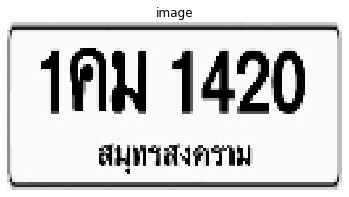

True    : 1คม1420-สมุทรสงคราม
Predict : 1คม1420-สมุทรสงคราม
_______________________________________


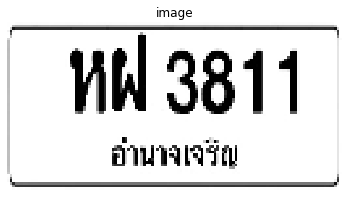

True    : Zหฝ3811-อำนาจเจริญ
Predict : Zหฝ3811-อำนาจเจริญ
_______________________________________


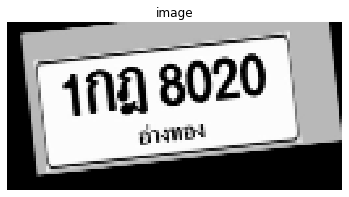

True    : 1กฎ8020-อ่างทอง
Predict : 1กฎ8020-ราชบุรี
_______________________________________


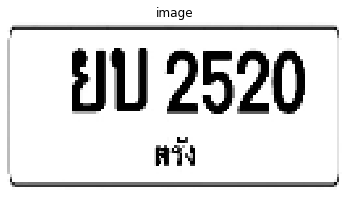

True    : Zยบ2520-ตรัง
Predict : Zยบ2520-ตรัง
_______________________________________


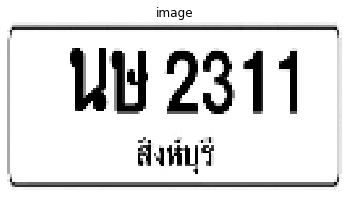

True    : Zนษ2311-สิงห์บุรี
Predict : Zนษ2311-สิงห์บุรี
_______________________________________


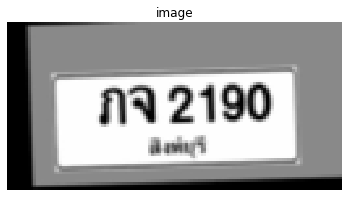

True    : Zภจ2190-สิงห์บุรี
Predict : Zภจ2190-ราชบุรี
_______________________________________


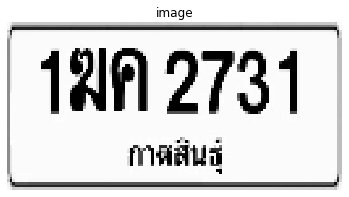

True    : 1ฆค2731-กาฬสินธุ์
Predict : 1ฆค2731-กาฬสินธุ์
_______________________________________


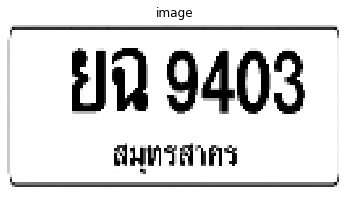

True    : Zยฉ9403-สมุทรสาคร
Predict : Zยฉ9403-สมุทรสาคร
_______________________________________


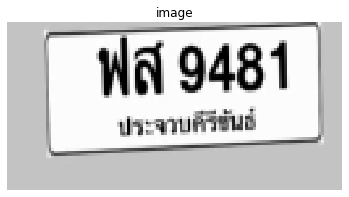

True    : Zฟส9481-ประจวบคีรีขันธ์
Predict : Zฟส9481-ประจวบคีรีขันธ์
_______________________________________


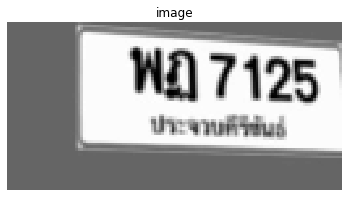

True    : Zพฏ7125-ประจวบคีรีขันธ์
Predict : Zพฏ7125-ประจวบคีรีขันธ์
_______________________________________


In [17]:
# Testing with Generated License Plate

test_dir = './DB/test/'
test_imgs = os.listdir(test_dir)

def display(img_, title=''):
    img = img_
#     fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

for test_img in sample(test_imgs,10):
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)

    net_out_value = loaded_model.predict(img_pred)

    pred_texts = decode_label(net_out_value)

    
    pred_texts_decoded = label_to_char(pred_texts)
    actual_texts_decoded = label_to_char(test_img[0:-4])
    
    try:
#         plate = cv2.imread(test_dir+test_img)
        plate = img.astype(np.float32)
        plate = cv2.resize(plate, (128, 64))
        plate = (plate / 255.0) * 2.0 - 1.0

        display(plate, 'image')
        print('True    :' , actual_texts_decoded)
        print('Predict :', pred_texts_decoded)
        print('_______________________________________') 
#         plt.axis('off')

    except:
        pass

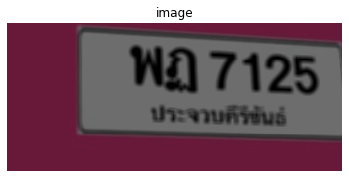

In [18]:
def display(img_, title=''):
    img = img_
#     fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()
plate = cv2.imread(test_dir+test_img)
display(plate, 'image')

In [4]:
test_dir = './DB/real_image/'
test_imgs = os.listdir(test_dir)

def display(img_, title=''):
    img = img_
#     fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

for test_img in test_imgs:
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)

    net_out_value = loaded_model.predict(img_pred)

    pred_texts = decode_label(net_out_value)

    
    pred_texts_decoded = label_to_char(pred_texts)
    actual_texts_decoded = label_to_char(test_img[0:-4])
    
    try:
#         plate = cv2.imread(test_dir+test_img)
        plate = img.astype(np.float32)
        plate = cv2.resize(plate, (128, 64))
        plate = (plate / 255.0) * 2.0 - 1.0
        
        display(plate, 'image')
        print('True    :' , actual_texts_decoded)
        print('Predict :', pred_texts_decoded)
        print('_______________________________________') 
#         plt.axis('off')

    except:
        pass

# Appendix 1

In [19]:
CHAR_VECTOR = "abcdefghijklmnopqrstuvwxyABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
letters = [letter for letter in CHAR_VECTOR]

In [20]:
def test_decode(out1):
    mystr = ''
    for i in out1:
        if i < len(letters):
            mystr += letters[i]
        else:
            mystr += '_'
    return mystr

In [21]:
net_out_value.shape

(1, 32, 62)

In [35]:
loaded_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64, 64)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
out1 = np.argmax(net_out_value[0, 2:], axis=1)
print(out1)

test_decode(list(out1))

[50  1  2  0 61 61 61 61 61 61 61 61 61 61 12 61 61 61 61 58 61 52 52 61
 53 53 56 56 26 49]


'Zbca__________m____7_11_2255BY'

In [23]:
out2 = [k for k, g in itertools.groupby(list(out1))]
print(out2)

test_decode(out2)

[50, 1, 2, 0, 61, 12, 61, 58, 61, 52, 61, 53, 56, 26, 49]


'Zbca_m_7_1_25BY'

In [24]:
mystr = ''
for i in out2:
    if i < len(letters):
        mystr += letters[i]
print(mystr)

Zbcam7125BY


In [28]:
label_to_char(mystr)

'Zพฏ7125-ประจวบคีรีขันธ์'

# Appendix 2

In [40]:
inv_char = {v: k for k, v in char_dict.items()}
inv_prov = {v: k for k, v in prov_dict.items()}

In [41]:
def convert(label):
    front_num = label[0]
    first_char = label[1:2]
    second_char = label[2:3]
    four_num = label[3:7]
    province = label[7:]


    try:
        first_char = inv_char[first_char]
    except:
        pass

    try:
        second_char = inv_char[second_char]
    except:
        pass

    try:
        province = inv_prov[province]
    except:
        pass        

    return print(front_num + first_char + second_char + four_num + province)

In [42]:
temp_str = 'Zพฎ7125ประจวบคีรีขันธ์'
convert(temp_str)

Zbcal7125BY
